## HERE PLACE THE GRAPHS AND THE ANALYSIS THAT HAVE TO BE DONE

The results that are going to be obtained at the end of the research will be the following:

Which are the jurisdictions in which entities found in Panama papers are registered?

- **Map the tax heavens jurisdiction in terms of the number of entities they have registered** DONE, TO BE PLACED IN DATA STORY


What countries have the most entities register in the Panama papers?

- **Map countries in the world according to how much they appear in the Panama Papers in terms of entities **DONE, TO BE PLACED IN DATA STORY


- **Use folium to make a map of the countries in terms of how mach they appear in the panama papers **, DONE, TO BE PLACED IN DATA STORY


What are the burocratic and economic causes pushing entities to go offshore? 


- **Investigate the role that the indicators 'Days to open a business', 'Tax rate', 'Time spent dealing with legal requirements', 'Ease of doing business coefficients' have in pushing entities and companies already to establish in countries which offer business friendly regulations **DONE. The conclusion is that corporate tax rate is the better indicator since data about the rest of the other indicators are missing and they much harder to find. Hence tables showing the lack of data will be presented in the notebook, but nothing of this will be put in the data story . 


- **Relationship between presence in Panama Papers and tax rate for G7 nations, for small developped and for developped and developping countries ** DONE, TO BE PLACED IN DATA STORY


How does the number of entities in a country which are mentioned in the Panama papers reflect with the social and income inequality within a country?


- **Show the evolution of income inequality and entities' presence in the Panama papers over time** DONE, NOT TO BE PLACED IN DATA STORY


- **Estimate how many resources could be lost by tax evasion by companies going ofsshore ** DONE, TO BE PLACED IN DATA STORY

In [1]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

# import othe useful packages
import os
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

# packages to improve visual description and analysis
from IPython.core.display import display
pd.set_option('display.max_columns', 100)

In [2]:
# Getting file names

DATA_FOLDER = './data/'

# Panama papers data
edges_csv = 'panama_papers.edges.csv'
intermediary_csv = 'panama_papers.nodes.intermediary.csv' # company or individuals
address_csv = 'panama_papers.nodes.address.csv'
officer_csv = 'panama_papers.nodes.officer.csv'
entity_csv = 'panama_papers.nodes.entity.csv' # tax heaven companies

# forbes data
forbes_csv = 'Forbes2015.csv'

The followings are the additional datasets used for the investigation taken in the [World Bank Dataset](https://data.worldbank.org):

- `API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv`, is the GINI coefficient per country

- `API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv`, is the GDP per country

- `API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv`, is the GDP per capita per country

- `API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv`, is the time spent by business in government regulation per country

- `API_GC.TAX.YPKG.RV.ZS_DS2_en_csv_v2_10227627.csv`, is the corporate tax rate per country

- `API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv`, days to open a business

Every dataset is divided in n rows as many countries in the world and p columns for a range p of years usually going from the sixties to 2018. Hence each column represent the indicator per year. Not all countries have an indicator each year. Examples are given in the notebook.

In [3]:
#World Bank dataset
GINI_coeff = 'API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv'
GDP_tot = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv'
GDP_cap = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv'
time_spent_by_bus = 'API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv'
tax_rate = 'API_IC.TAX.TOTL.CP.ZS_DS2_en_csv_v2_10226097.csv'
days_open_business='API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv'

In [4]:
# Importing the Panama Papers data into DataFrames
df_edges_raw = pd.read_csv(DATA_FOLDER + edges_csv,low_memory=False)
df_address_raw = pd.read_csv(DATA_FOLDER + address_csv,low_memory=False)
df_entity_raw = pd.read_csv(DATA_FOLDER + entity_csv,low_memory=False)
df_intermediary_raw = pd.read_csv(DATA_FOLDER + intermediary_csv,low_memory=False)
df_officier_raw = pd.read_csv(DATA_FOLDER + officer_csv,low_memory=False)

FileNotFoundError: File b'./data/panama_papers.nodes.entity.csv' does not exist

In [ ]:
#Importing World Bank Data
df_GDP_tot_raw=pd.read_csv(DATA_FOLDER + GDP_tot,skiprows=4)
df_GDP_cap_raw=pd.read_csv(DATA_FOLDER + GDP_cap,skiprows=4)
df_tax_weight=pd.read_csv(DATA_FOLDER+tax_rate, skiprows=4)
df_ease_business=pd.read_csv(DATA_FOLDER+days_open_business,skiprows=4)
df_gini=pd.read_csv(DATA_FOLDER+GINI_coeff, skiprows=4)
df_time_regulation=pd.read_csv(DATA_FOLDER+days_open_business, skiprows=4)

## Handling data size

First we will answer the question of whether we can handle the data in size.

In [6]:
# Printing shapes of each DataFrame to see if any are too large

print("Edges shape: ", df_edges_raw.shape)
print("Intermediary shape: ", df_intermediary_raw.shape)
print("Address shape: ", df_address_raw.shape)
print("Officer shape: ", df_officier_raw.shape)
print("Entity shape: ", df_entity_raw.shape)

Edges shape:  (674102, 8)
Intermediary shape:  (14110, 8)
Address shape:  (93454, 8)
Officer shape:  (238402, 7)
Entity shape:  (213634, 17)


From above, we see that the DataFrame with the most number of rows is around 670,000 rows of data. In total the size of the Panama Papers dataset is around 352 MB, which is small enough for Jupyter Notebook and Pandas to handle effectively. Thus the data can definitely be handled within our approach of using purely a notebook. 

## Understanding the data

Next we understand the data. Although the dataset is downloaded within `csv` format, the data is curated to work well within a graph database (specifically Neo4j as mentioned on the Panama Papers website). Here, the `Edges` table represents the edge connections within a graph database whereas all the other tables (`Intermediary`, `Address`, etc) are nodes within the graph. For example:

In [7]:
display(df_edges_raw.head(1))

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,10000035,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN


To interpret this row in the `Edges` table, the `START_ID` and `END_ID` represent the node ids that the edge is connected to. But the node ids can correspond to any of `Intermediary, Address, Officer, Entity`, which may prove to be difficult in SQL or Pandas merging as we will have to look up the node id in every other table. One solution would be to use Neo4j and the Cypher querying language, which can be used to easily interpret the above information. Below we can see clearly that the start node is an Entity named *CARPENTER NELSON & CO., LTD* and the end node is an Address named *EUROFIN SERVICES S.A. P.O.BOX  6003 LAUSANNE 1002, VAUD SWITZERLAND* and the relationship type is *registered address*.

<img src="ex_query1.png" height="400" width="1000">

For the purposes of our project, we may not even need to use Neo4j to answer our queries. However we have done the above analyis to identify the format of our data, which is crucial because if we do require a certain query, we understand how we can leverage different tools to achieve our goals.

## Data Cleaning

We see that `Edges` Dataframe and `Entity` Dataframe have mixed datatypes in their columns so we will inspect those more clearly. 

In [8]:
start_dates = df_edges_raw.start_date.unique()[1:]
start_dates = sorted(list(map(lambda x: int(x[-4:]), start_dates)), reverse=True)
print(start_dates[:20])
print(start_dates[-50:])

[2500, 2205, 2201, 2099, 2088, 2088, 2020, 2019, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015]
[1974, 1973, 1973, 1972, 1968, 1966, 1965, 1959, 1957, 1957, 1194, 214, 213, 213, 206, 203, 202, 201, 201, 201, 200, 200, 200, 200, 200, 200, 200, 200, 199, 199, 96, 95, 82, 15, 14, 12, 12, 12, 12, 12, 12, 12, 12, 11, 9, 9, 6, 6, 4, 3]


We first see that the start_date and end_date columns in `Edges` have dates that are nonsensical, such as years that are well before/after 2015. Upon consideration of our research questions, we decide to drop the date columns from `Edges` as well as the Note column in `Entity` (For our research question of timeline of leaked papers, we will need to use the `Entity['incorporation_date']` column).

In [9]:
edges = df_edges_raw.drop(columns=['start_date', 'end_date'])
entity = df_entity_raw.drop(columns=['note'])

Furthermore, we see that the `Entity['incorporation_date']` column have acceptable ranges below so we will convert that column from type object to date.

In [10]:
print(entity['incorporation_date'].sort_values().unique())
entity.incorporation_date = pd.to_datetime(entity.incorporation_date)

['01-APR-1975' '01-APR-1977' '01-APR-1981' ... '31-OCT-2013' '31-OCT-2014'
 nan]


# The Panama Papers

The Panama Papers are leaked documents that detail financial and attorney–client information for offshore entities. The documents were created by, and taken from, Panamanian law firm and corporate service provider Mossack Fonseca, and were leaked in 2015 by an anonymous source.

As shown by the exploratory analysis, the entity document of the Panama Papers is very interesting: it provides a macroscopic view of how many entities per countries are involved in settling companies offshore or funds offshore. The reasons behind making an offshore company are multiple: setting a company offshore is not a crime, but it can be an indication that the business condition in the home country are not always favorable from a privacy point of view, from a bureaucratic point of view and from a tax point of view. Hence it is crucial to understand why entities decide to set their companies offshore and what is the consequence on the home country from a wealth distribution point of view. To carry out this investigation a set of questions which provide a guideline for this analysis are going to be answered

**1)** Which are the jurisdictions in which entities found in Panama papers are registered?

**2)** What countries have the most entities register in the Panama papers?

**3)** Are there burocratic and economic causes pushing entities to go offshore ?

**4)** What are the consequences of offshore companies on income inequality?

### 1) Which are the jurisdictions in which entities found in Panama papers are registered?

Here the jurisdiction column of the entity file is considered. It represents the county where the offshore entity is register.

In [11]:
df_entity_raw['jurisdiction_description'].unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'British Anguilla', 'Seychelles',
       'Niue', 'Uruguay', 'British Virgin Islands', 'Hong Kong',
       'New Zealand', 'Bahamas', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica'], dtype=object)

To better represent all the country present on different graph, all the countries appearing less times than a certain number called here threshold are grouped and considered in following steps as `Others`.

In [12]:
threshold1=1000
df_entity_S1=df_entity_raw.copy()
vc=df_entity_S1.jurisdiction_description.value_counts()
tax_heavens_L=list(vc[vc > threshold1].index)
tax_heavens_S=list(vc[vc <= threshold1].index)
df_entity_S1.loc[~df_entity_S1.jurisdiction_description.isin(tax_heavens_L), 'jurisdiction_description'] = 'Others'
df_entity_S1.jurisdiction_description.value_counts()

British Virgin Islands    113648
Panama                     48360
Bahamas                    15915
Seychelles                 15182
Niue                        9611
Samoa                       5307
British Anguilla            3253
Nevada                      1260
Others                      1098
Name: jurisdiction_description, dtype: int64

A simple histogram is plotted. Logarithmic scale on the $y-axis$ is later applied noticed an approximated exponential distribution. It could be an interesting aspect to investigate. 

Countries in Others category are:  ['Hong Kong', 'United Kingdom', 'Belize', 'Costa Rica', 'Cyprus', 'Uruguay', 'New Zealand', 'Jersey', 'Wyoming', 'Malta', 'Isle Of Man', 'Ras Al Khaimah', 'Singapore']


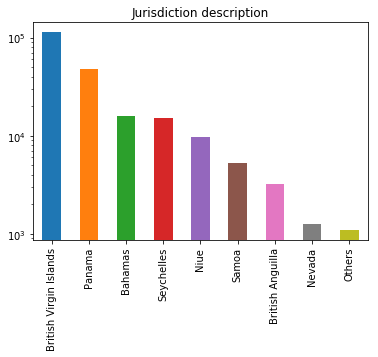

In [13]:
df_entity_S1.jurisdiction_description.value_counts().plot(kind='bar',title='Jurisdiction description', logy=True)
print('Countries in Others category are: ',tax_heavens_S)

A pie chart is also plotted. As mentioned above a heat map of the distribution around the world will be represented.

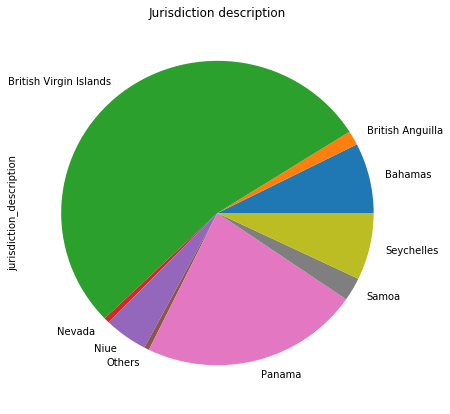

In [14]:
df_entity_S1.jurisdiction_description.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Jurisdiction description')

## 2) What countries have the most entities register in the Panama papers?

The same procedure is applied to the `country` column representing the country of origin of the offshore company. As more country are included a bigger threshold needs to be chosen in order to make the plots still readable. Same as before, the count of companies for country will be represent on a heat map.

In [15]:
df_entity_raw['countries'].unique()

array(['Hong Kong', 'Taiwan', 'China', 'Switzerland', 'Singapore',
       'Brazil', 'Panama', 'Samoa', 'Liechtenstein', 'Spain', 'Thailand',
       'Colombia', 'Jersey', 'Andorra', 'Seychelles', 'Ireland',
       'Belgium', 'Israel', 'Gibraltar', 'Guernsey',
       'United Arab Emirates', 'Cyprus', 'Venezuela', 'Isle of Man',
       'Lebanon', 'Denmark', 'Uruguay', 'Jordan', 'Bahamas',
       'United Kingdom', nan, 'Belize', 'Luxembourg', 'Ecuador',
       'Guatemala', 'Germany', 'Mauritius', 'Turkey', 'United States',
       'Monaco', 'Estonia', 'Niue', 'Czech Republic', 'Netherlands',
       'Hungary', 'Costa Rica', 'Portugal', 'Cayman Islands',
       'South Africa', 'Malta', 'New Zealand', "Côte d'Ivoire",
       'Dominican Republic', 'France', 'Italy', 'Canada', 'Russia',
       'Greece', 'Saudi Arabia', 'Qatar', 'Mexico', 'Peru', 'Bermuda',
       'El Salvador', 'Australia', 'Saint Kitts and Nevis', 'Argentina',
       'Japan', 'Austria', 'American Samoa', 'Paraguay', 'Chile', 'E

In [16]:
threshold2=3000
vc=df_entity_S1.countries.value_counts()
tax_evasions_L=list(vc[vc > threshold2].index)
tax_evasions_S=list(vc[vc <= threshold2].index)
df_entity_S1.loc[~df_entity_S1.countries.isin(tax_evasions_L), 'countries'] = 'Others'
df_entity_S1.countries.value_counts()

Hong Kong               37911
Switzerland             37911
Others                  36495
Panama                  15811
Jersey                  14331
Luxembourg              10840
United Kingdom           9619
Guernsey                 7327
United Arab Emirates     7269
Bahamas                  4984
Uruguay                  4906
Isle of Man              4892
Russia                   4197
Singapore                4081
Cyprus                   3613
China                    3213
Monaco                   3168
United States            3066
Name: countries, dtype: int64

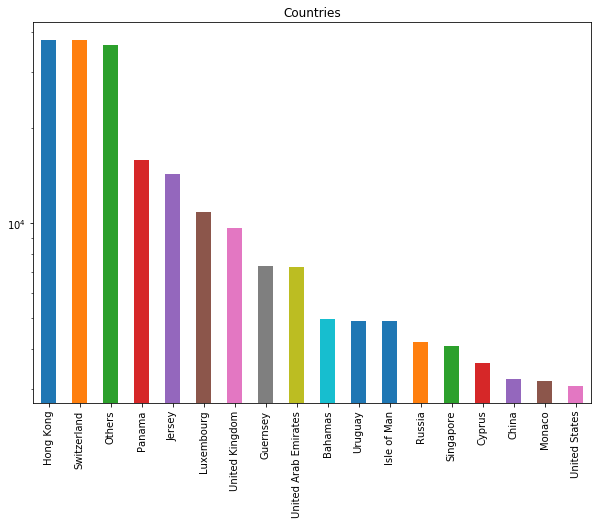

In [17]:
df_entity_S1.countries.value_counts().plot(kind='bar',title='Countries', figsize=(10, 7), logy=True)

The value of the `Others` column is very high indicating a quite heavy tail distribution. As before, plotting the bar chart with a logarithm $y-axis$, seems that the distribution has a exponential behaviour at least his first part. 

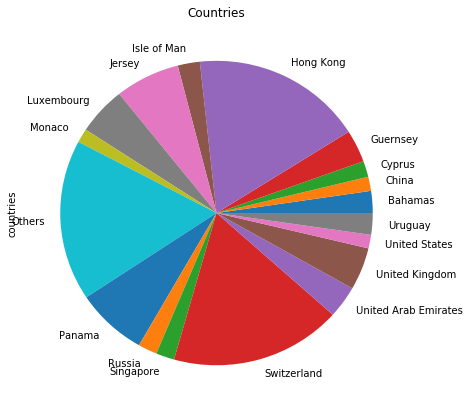

In [18]:
df_entity_S1.countries.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Countries')

An interesting fact can be notice from the distribution of the countries. The majority of the entities present in the papers come from a country with already favourable business condition like Honk Kong, Switzerland and Luxembourg or even from a place considered a fiscal paradise (Panama, Jersey). This fact can be explained with a tendency, amplified by globalization, of big companies of starting their international business already from a convenient economy. Later queries will need to take into account these facts, maybe weighting output by indicator of the economic situation of the county of origin. 
More analysis on this aspect will be performed.


### GDP Data Integration Analysis

In order to go further with the investigation it is crucial to have an instrument to distinguish between categories of countries. The parameters used to do so are the Total Gross Domestic Product and the Gross Domestic Product per capita which are measures of the size of the economic activity in a country and population. Hence, using these two paramters the number of entities present in the Panama Papers will be weighted according to these indicators too.

$GDP_{cap}$

As many of the operation performed with the GDP will involve an inner joint between the latter and the entity data frame, the correctness of the operation is investigated. 

In [19]:
df_GDP_tot_raw

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.330168e+09,1.320670e+09,1.379888e+09,1.531844e+09,1.665363e+09,1.722799e+09,1.873453e+09,1.920263e+09,1.941095e+09,2.021302e+09,2.228279e+09,2.331006e+09,2.421475e+09,2.623726e+09,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,2.516000e+09,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,1.373333e+09,1.408889e+09,1.748887e+09,1.831109e+09,1.595555e+09,1.733333e+09,2.155555e+09,2.366667e+09,2.555556e+09,2.953333e+09,3.300000e+09,3.697940e+09,3.641723e+09,3.478788e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.461666e+09,4.128821e+09,4.583644e+09,5.285466e+09,6.275074e+09,7.057598e+09,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,5.784342e+09,6.131475e+09,7.553560e+09,7.072063e+09,8.083872e+09,8.769251e+09,1.020110e+10,1.122876e+10,1.060378e+10,8.307811e+09,5.768720e+09,4.438321e+09,5.538749e+09,7.526447e+09,7.648377e+09,6.506230e+09,6.152923e+09,9.129595e+09,8.936064e+09,1.249735e+10,1.418895e+10,1.964085e+10,2.823371e+10,4.178948e+10,6.044892e+10,8.417804e+10,7.549239e+10,8.252614e+10,1.040000e+11,1.140000e+11,1.250000e+11,1.270000e+11,1.030000e+11,9.533720e+10,1.240000e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.924242e+09,1.965385e+09,2.173750e+09,2.156625e+09,2.126000e+09,2.335125e+09,2.101625e+09,1.139167e+09,7.094526e+08,1.228071e+09,1.985674e+09,2.424499e+09,3.314898e+09,2.359903e+09,2.707124e+09,3.414761e+09,3.632044e+09,4.060759e+09,4.435079e+09,5.746946e+09,7.314865e+09,8.158549e+09,8.992642e+09,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861921e+07,8.940982e+07,1.134082e+08,1.508201e+08,1.865587e+08,2.201272e+08,2.272810e+08,2.540202e+08,3.080089e+08,4.115783e+08,4.464161e+08,3.889587e+08,3.758960e+08,3.278618e+08,3.300707e+08,3.467380e+08,4.820006e+08,6.113164e+08,7.214259e+08,7.954493e+08,1.029048e+09,1.106929e+09,1.210014e+09,1.007026e+09,1.017549e+09,1.178739e+09,1.223945e+09,1.180597e+09,1.211932e+09,1.239876e+09,1.434430e+09,1.496913e+09,1.733117e+09,2.398646e+09,2.935659e+09,3.255789e+09,3.543257e+09,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09
5,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.575266e+10,2.842535e+10,3.137573e+10,3.641557e+10,4.330257e+10,5.500127e+10,1.050000e+11,1.160000e+11,1.450000e+11,1.670000e+11,1.830000e+11,2.490000e+11,3.380000e+11,3.480000e+11,3.240000e+11,3.040000e+11,3.080000e+11,3.040000e+11,2.890000e+11,3.130000e+11,3.070000e+11,3.220000e+11,4.470000e+11,4.400000e+11,4.710000e+11,4.760000e+11,4.870000e+11,5.230000e+11,5.780000e+11,6.130000e+11,5.910000e+11,6.430000e+11,7.350000e+11,7.230000e+11,7.290000e+11,8.230000e+11,9.640000e+11,1.180000e+12,1.400000e+12,1.640000e+12,2.080000e+12,1.800000e+12,2.110000e+12,2.500000e+12,2

All the following numbers printed show the condition of the data frame as it is right now, after performing the operation later described. The year with less missing values among the ones that follow the 2008 economic crisis (meaning comparable GDP to the present ones) is chosen as measure of the GDP. It is 2014 with 16 missing values.

In [20]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

30
23
18
9
16
17


In [21]:
df_GDP_tot=df_GDP_tot_raw[['Country Name','2014']].copy()
df_GDP_tot.columns = ['countries', 'GDP_tot']
#df_GDP_tot

A new data frame from the `entity` one is created with only the relevant columns. (value_counts is applied) 

In [22]:
df_vc=pd.DataFrame(df_entity_raw.countries.value_counts())
df_vc.reset_index(level=0, inplace=True)
df_vc.columns = ['countries', 'n_companies']
#df_vc

Now a merge with an inner join the value counts data frame `df_vc` and the `df_GDP_tot` is performed. All the lines with a missing GDP were visualized below (lines of British Virgin Islands, Turks and Caicos Island, Sint Marteen (dutch part), Monaco, Gibraltar, Cayman Islands, Bermuda and Aruba).  The missing values are manually integrated in the `.csv` looking at reliable data online. The check for nan values now shows an empty dataframe.

In [23]:
df_GDP_tot_entities=df_GDP_tot.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_tot_entities[df_GDP_tot_entities['GDP_tot'].isna()])
#df_GDP_tot_entities

Number of countries without GDP in the database:  Empty DataFrame
Columns: [countries, GDP_tot, n_companies]
Index: []


$GDP_{tot}$

The same analysis procedure is performed on the GDP pro capita data frame. The same lines of GDP were missing, and they were replaced in the same manner as for the total GDP.

In [24]:
df_GDP_cap_raw

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17342.471940,16441.790640,16585.195530,17926.572840,19081.351660,19356.203390,20620.700630,20670.655660,20434.299440,20834.510200,22567.824920,23302.831990,24014.944270,25921.026050,27546.899390,24631.434860,24271.940420,25324.720360,NaN,NaN,25300.000000,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,5.977733e+01,59.878153,58.492874,78.782758,82.208444,101.290471,137.899362,161.322000,129.506654,129.798541,157.187422,160.372836,136.117014,144.110319,174.942038,187.975604,199.026173,226.005344,249.287386,277.900742,274.880859,266.493042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.409691,187.845095,198.728544,219.141353,250.294130,272.563077,369.835796,373.361116,445.893298,553.300289,603.537023,669.009051,638.612543,629.345250,569.577923,561.778746,585.850064
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.117560,600.408766,579.252001,582.420126,596.602467,711.992700,647.563354,720.598939,761.618458,862.509058,922.550170,844.691134,640.622298,430.381595,320.657792,388.166766,512.620966,506.884952,419.639845,385.768854,555.296942,526.168743,711.181789,779.468317,1041.087109,1443.991924,2062.415212,2878.837305,3868.579014,3347.844900,3531.416878,4299.008136,4539.467689,4804.633826,4707.578098,3683.552607,3308.772828,4170.312280
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662.520052,662.914793,719.157296,699.384292,676.566733,723.409610,639.463899,348.711318,218.492166,380.527371,619.065163,760.559376,1046.358511,749.584649,865.302162,1098.425463,1175.788981,1326.970339,1453.642777,1890.681557,2416.588235,2709.142931,3005.012903,3603.013685,4370.539647,4114.136545,4094.358832,4437.178068,4247.614308,4413.081697,4578.666728,3952.830781,4131.872341,4537.862492
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3238.556850,3498.173652,4217.173581,5342.168560,6319.739034,7169.101006,7152.375134,7751.370216,9129.706185,11820.849390,12377.411650,10372.232830,9610.266308,8022.654781,7728.906695,7774.393829,10361.815980,12616.167570,14304.356960,15166.437850,18878.505970,19532.540150,20547.711790,16516.471030,16234.809010,18461.064860,19017.174590,18353.059720,18894.521500,19261.710500,21936.530100,22228.846490,24741.493570,32776.442270,38503.479610,41282.020120,43748.772160,48582.808460,47785.659090,43339.379870,39736.354060,41098.766940,38391.080870,40619.711300,42294.994730,36038.267600,37231.815670,39146.548840
5,Arab World,ARB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222.619525,238.835301,256.341059,289.454866,334.979353,413.968484,768.950696,825.746103,996.344273,1114.053418,1182.459061,1549.753370,2040.396013,2037.300791,1837.087828,1669.550456,1640.870234,1571.561422,1451.271809,1525.229081,1457.979269,1486.363103,1987.839701,1904.616034,2004.009905,1974.275775,1969.702345,2052.143033,2215.934915,2299.151057,2169.789213,2313.789971,2588.742903,2495.366312,2462.791442,2721.615721,3117.660806,3745.790931,4336.718583,4937.598216,6115.243747,5158.250506,5917.245724,6854.844526,7463.399723,7508.573301,7452.814677,6413.377161,6151.180927,6251.141575
6,United Arab Emirates,ARE,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [25]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

30
23
18
9
16
17


In [26]:
df_GDP_cap=df_GDP_cap_raw[['Country Name','2014']].copy()
df_GDP_cap.columns = ['countries', 'GDP_cap']
#df_GDP_cap

In [27]:
df_GDP_cap_entities=df_GDP_cap.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_cap_entities[df_GDP_cap_entities['GDP_cap'].isna()])
df_GDP_cap_entities

Number of countries without GDP in the database:  Empty DataFrame
Columns: [countries, GDP_cap, n_companies]
Index: []


Eventually it is important to mention that a number of countries had different spelling in the World Bank data relatively to the names given in the Panama Papers. Hence since the number of these incongruencies was lower than 15, the names were changed manually in the Panama Paper document excel. On top of that certain small countries/islands didn't have data relative to the GDP singularly and they were included by the World Bank in bigger group of countries: for example Jersey and Guernsey are included under the name 'Channel Islands' in the World Bank dataset. Hence the names were changed in the Panama Papers dataset.

## 3) What drives entities to go offshore and consequently how does that affect the country?

## 4) What are the consequences of offshore companies on income inequality?

# Old storyline for milestone 2

**Investigate the role that the indicators 'Days to open a business', 'Tax rate', 'Time spent dealing with legal requirements', 'Ease of doing business coefficients' have in pushing entities and companies already to establish in countries which offer business friendly regulations**

In [28]:
country_count=pd.DataFrame(df_entity_raw['countries'].value_counts())

Firstly a dataframe with the country and the respective number of entities in the Panama Papers is made. This is used as a base to subsequentially add information regarding the indicators.

In [29]:
country_count=country_count.rename(columns={'countries': 'n_companies_offshore'})
country_count['Country Name']=country_count.index
country_count=country_count.reset_index(drop=True)

In [30]:
country_count.head()

,n_companies_offshore,Country Name
0,37911,Hong Kong
1,37911,Switzerland
2,15811,Panama
3,14331,Jersey
4,10840,Luxembourg


In order to investigate the relationship between income inequality and number of entities in the Panama papers per country, the number of entities per country has to be weighted according to economical size: without doing so, big economies will automatically have a higher number of entities registered in the papers only because they are bigger. Hence GDP and GDP per capita are going to be used as weighting factor for the number of registered entities in papers, n: 

\begin{equation*}
n_{w}=\frac{n}{GDP_{indicator}}
\end{equation*}

In [31]:
# name formatting 
df_gdp=df_GDP_tot_raw
df_gdp_capita=df_GDP_cap_raw

In [32]:
df_countries_gdp_capita=pd.DataFrame({'Country Name':df_gdp_capita['Country Name'][df_gdp_capita['2014'].notnull()],'GDP':df_gdp_capita['2014'][df_gdp_capita['2014'].notnull()]})

In [33]:
df_countries_gdp=pd.DataFrame({'Country Name':df_gdp['Country Name'][df_gdp['2014'].notnull()],'GDP':df_gdp['2014'][df_gdp['2014'].notnull()]})

In [34]:
# count in panama papers and gdp is merged in one dataframe
country_count_gdp=country_count.merge(df_countries_gdp, how='inner',left_on='Country Name', right_on='Country Name')

In [35]:
# count in panama papers and gdp per capita is merged in one dataframe
country_count_gdp=country_count_gdp.merge(df_countries_gdp_capita, how='inner',left_on='Country Name', right_on='Country Name')

In [36]:
country_count_gdp.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y
0,37911,Switzerland,7.090000e+11,86605.56338
1,15811,Panama,4.992146e+10,12787.30620
2,10840,Luxembourg,6.632734e+10,119225.38000
3,9619,United Kingdom,3.020000e+12,46783.46922
4,7269,United Arab Emirates,4.030000e+11,44443.06151


As highlighted initially, there is a chunck of entities/companies which are registered in Panama papers and which come already from countries with favorable business conditions. Hence it will be important to understand what are these favorable conditions. The year with most data regarding each indicator will be considered assuming that the change in each indicator in the last 10 years is irrelevant. In order to explore the role of each indicator, interactive plots are created to better investigate individually what are the conditions which push entities to go offshore.

#### Tax Rate

Chances of having lower tax rates already push companies to have holdings in tax havens. Do greater tax rates correspond with higher income inequality?

In [37]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_tax_weight[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2013


In [38]:
df_countries_tax=pd.DataFrame({'Country Name':df_tax_weight['Country Name'][df_tax_weight['2013'].notnull()],'Tax Rate':df_tax_weight['2013'][df_tax_weight['2013'].notnull()]})

In [39]:
df_countries_tax.head()

,Country Name,Tax Rate
1,Afghanistan,35.600000
2,Angola,52.600000
3,Albania,31.700000
5,Arab World,42.157143
6,United Arab Emirates,14.800000


The distribution of the tax rate overall is found

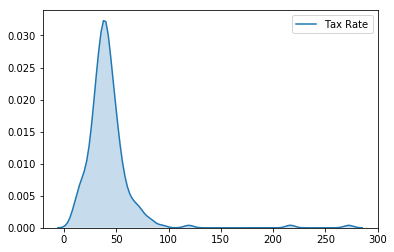

In [40]:
sns.kdeplot(df_countries_tax['Tax Rate'], shade=True)

A dataset with tax rate and number of companies registered in the panama papers is made.

In [41]:
country_count_tax_rate=country_count_gdp.merge(df_countries_tax, how='inner',left_on='Country Name', right_on='Country Name')

In [42]:
country_count_tax_rate.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y,Tax Rate
0,37911,Switzerland,7.090000e+11,86605.56338,28.8
1,15811,Panama,4.992146e+10,12787.30620,37.0
2,10840,Luxembourg,6.632734e+10,119225.38000,20.4
3,9619,United Kingdom,3.020000e+12,46783.46922,34.7
4,7269,United Arab Emirates,4.030000e+11,44443.06151,14.8


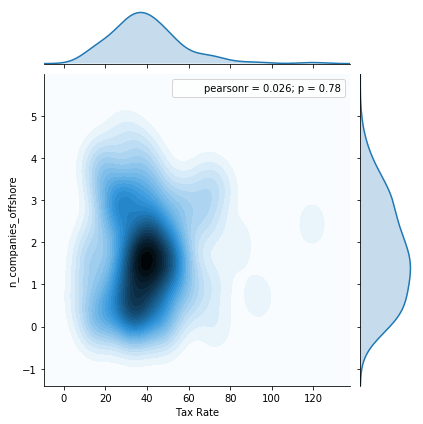

In [43]:
sns.jointplot(country_count_tax_rate['Tax Rate'],np.log10(country_count_tax_rate['n_companies_offshore']), kind="kdeplot", n_levels=30)

Below an interactive graph showing the relationship between the tax rate and the number of offshore entities is made to investigate a relationship between the two variables and look how each country behave.

In [44]:
x = country_count_tax_rate['Tax Rate']
y = np.log10(country_count_tax_rate['n_companies_offshore']/country_count_tax_rate['GDP_y'])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_tax_rate['Tax Rate']),
    y=list(np.log10(country_count_tax_rate['n_companies_offshore']/country_count_tax_rate['GDP_y'])),
    country=list(country_count_tax_rate['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover])

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("tax rate.html", title="Tax Rate plot")

show(p)

### Ease of Business coefficient

Chances of having better business already push companies to have holdings in tax havens or semi tax haven countries such as Singapore, Switzerland or Hong Kong. How much weight does this coefficient have?

In [45]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_ease_business[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2017


In [46]:
df_countries_ease_business=pd.DataFrame({'Country Name':df_ease_business['Country Name'][df_ease_business['2017'].notnull()],'days_open_business':df_ease_business['2017'][df_ease_business['2017'].notnull()]})

In [47]:
df_countries_ease_business.head()

,Country Name,days_open_business
1,Afghanistan,183.0
2,Angola,175.0
3,Albania,65.0
6,United Arab Emirates,21.0
7,Argentina,117.0


In [48]:
country_count_ease_business=country_count_gdp.merge(df_countries_ease_business, how='inner',left_on='Country Name', right_on='Country Name')

The distribution of the ease of business coefficients is found

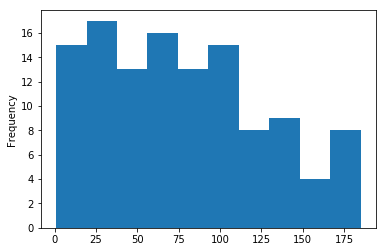

In [49]:
country_count_ease_business['days_open_business'].plot(kind='hist')

In [50]:
country_count_ease_business.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y,days_open_business
0,37911,Switzerland,7.090000e+11,86605.56338,33.0
1,15811,Panama,4.992146e+10,12787.30620,79.0
2,10840,Luxembourg,6.632734e+10,119225.38000,63.0
3,9619,United Kingdom,3.020000e+12,46783.46922,7.0
4,7269,United Arab Emirates,4.030000e+11,44443.06151,21.0


A dataset with ease of business conditions and number of companies registered in the panama papers is made.

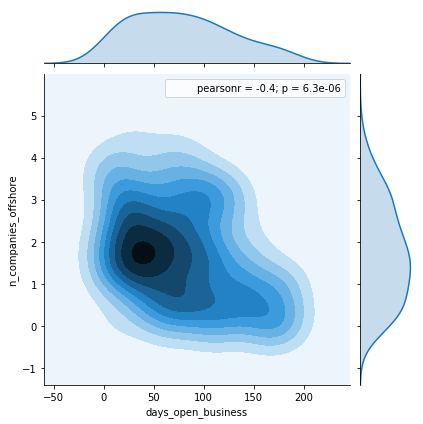

In [51]:
sns.jointplot(country_count_ease_business['days_open_business'],np.log10(country_count_ease_business['n_companies_offshore']), kind='kde')

In [52]:
x = country_count_ease_business['days_open_business']
y = np.log10(country_count_ease_business['n_companies_offshore']/country_count_ease_business['GDP_y'])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_business['days_open_business']),
    y=list(np.log10(country_count_ease_business['n_companies_offshore']/country_count_ease_business['GDP_y'])),
    country=list(country_count_ease_business['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(days to open business, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover])

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("days_open_business.html", title="Days open business plot")

show(p)

#### Example of Gini Coefficient Analysis

Finally an example of how the above mentioned coefficients will be used as weighting factors to investigate income inequality is given for tax rate.

In [53]:
df_gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_gini[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2010


In [55]:
df_countries_gini=pd.DataFrame({'Country Name':df_gini['Country Name'][df_gini['2010'].notnull()],'Gini Coefficient':df_gini['2010'][df_gini['2010'].notnull()]})

In [56]:
df_countries_gini.head()

,Country Name,Gini Coefficient
7,Argentina,43.0
8,Armenia,30.0
11,Australia,34.7
12,Austria,30.3
15,Belgium,28.4


In [57]:
country_count_gini=country_count_gdp.merge(df_countries_gini, how='inner',left_on='Country Name', right_on='Country Name')

In [58]:
country_count_gini=country_count_gini.merge(df_countries_tax, how='inner',left_on='Country Name', right_on='Country Name')

In [59]:
country_count_gini.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y,Gini Coefficient,Tax Rate
0,37911,Switzerland,7.090000e+11,86605.56338,32.6,28.8
1,15811,Panama,4.992146e+10,12787.30620,51.7,37.0
2,10840,Luxembourg,6.632734e+10,119225.38000,30.5,20.4
3,9619,United Kingdom,3.020000e+12,46783.46922,34.4,34.7
4,4906,Uruguay,5.723601e+10,16737.89827,44.5,41.8


The graph below shows that by taking account of multiple factors which influence a business to have an offshore holding and investigate the relationship with income inequality an interesting result arises. There seems to be a positive relationship between income inequality and presence in the panama papers. This suggests that even if entities move their capitals/businesses offshore without the intention of evading taxes, the discrepancy between the business conditions with their own home country can correlate with high income inequality. This is the case of some countris in Latin America such as Colombia, Uruguay, Ecuador, Costa Rica and Paraguay.

In [60]:
x = country_count_gini['Gini Coefficient']
y = np.log10(country_count_gini['n_companies_offshore']*country_count_gini['Tax Rate']/country_count_gini['GDP_y'])

# radii = country_count_gini['Gini Coefficient']
# radii=list(country_count_gini['Gini Coefficient']*0.05),

source=ColumnDataSource(data=dict(
    x=list(country_count_gini['Gini Coefficient']),
    y=list(np.log10(country_count_gini['n_companies_offshore']*country_count_gini['Tax Rate']/country_count_gini['GDP_y'])),
    country=list(country_count_gini['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(Gini, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover])

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("gini.html", title="Gini Coefficient plot")

show(p)

### Evolution in Time

To answer the second question, we will look at the incorporation dates of different entities and groupby count by year to plot a time series chart.

In [61]:
entity['Year'] = entity.apply(lambda row: row['incorporation_date'].year, axis=1)

In [62]:
series = entity.groupby(['Year'], axis=0)['Year'].count()

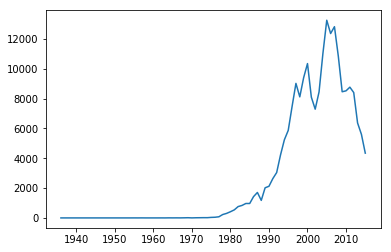

In [63]:
x = series.index.tolist()
y = series.tolist()

plt.plot(x,y)
plt.show()

Thus we observe that the number of incorporations peaked between 20